# Task 4 - CNN


Results:
Adam learning rate: 0.005
Gd learning rate: 0.5
Decay: 0.96 every 500 iter

Adam without dropout, without decay
Final test accuracy 0.8927
Final test loss 0.50648

Adam without dropout, with decay
Final test accuracy 0.897
Final test loss 0.508396

gd-no-deacy-no-reg
Final test accuracy 0.1282
Final test loss 2.214514

adam-decay-reg
Final test accuracy 0.8882
Final test loss 0.354514

Observations:

Results show that AdamOptimizer was better than GD, and that AdamOptimizer with decay peformed best. We however did not see much change in the accuracy even after adding dropout which is slighly surprising since we see that there is some overfitting so it should be possible to increase the test accuracy a bit. when we added dropout, we got less overfitting but lesser accuracy as well.We use the SAME padding here and our stride here is 1, so the input will preserve the dimension. Thus in our case the input dimensions are transformed as:
1x28x28 -> 4x28x28 -> 8x14x14 -> 12x7x7 -> 588 -> 10
The downsampling is due to stride > 1, and the FCC flattens the dimensions and softmax squashes it to 10 probabilities.

In [2]:
from __future__ import print_function
# all tensorflow api is accessible through this
import tensorflow as tf
import numpy as np
# to visualize the results
import matplotlib.pyplot as plt
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data

# Enable deterministic comparisons between executions
tf.set_random_seed(0)

#Initializing values for the constants used below
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
NUM_CLASSES = 10
NUM_HIDDEN_1 = 200
NUM_HIDDEN_2 = 100
NUM_HIDDEN_3 = 60
NUM_HIDDEN_4 = 30
DROPOUT_RATE = 0.5
GD_LEARNING_RATE = 0.5
ADAM_LEARNING_RATE = 0.005

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
y = 7 (Sneaker)


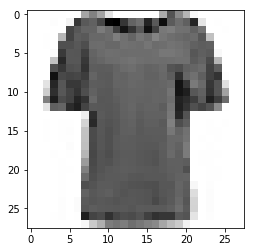

y = 1 (Trouser)


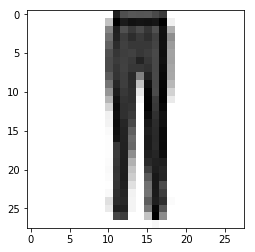

Number of train examples in dataset 55000
Number of test examples in dataset 10000
Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)


In [3]:

# load data
tf.set_random_seed(0)
# load data
mnist = input_data.read_data_sets('data/fashion', one_hot=True)

# Just used for personal reference
label_dict = {
 0: 'T-shirt-top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

#Checking to see if we got the right data set.
# Get 28x28 image
sample_1 = mnist.train.images[123].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_1 = np.where(mnist.train.labels[183] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

# Sample 2

# Get 28x28 image
sample_2 = mnist.train.images[190].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_2 = np.where(mnist.train.labels[190] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_2, label=label_dict[sample_label_2]))
plt.imshow(sample_2, cmap='Greys')
plt.show()

print('Number of train examples in dataset ' + str(len(mnist.train.labels)))
print('Number of test examples in dataset ' + str(len(mnist.test.labels)))
print("Training set (images) shape: {shape}".format(shape= mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=mnist.train.labels.shape))

In [4]:
# load data
mnist = input_data.read_data_sets('../data/fashion', one_hot=True, validation_size=0)

print('Number of train examples in dataset ' + str(len(mnist.train.labels)))
print('Number of test examples in dataset ' + str(len(mnist.test.labels)))

# Define placeholders for input data and for input truth labels
x = tf.reshape(tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 1]),
               [-1, IMAGE_PIXELS])  # training examples (just one color channel, i.e grayscale)
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])  # correct answers(labels)


# Define variables for the parameters of the model: Weights and biases, random-initialization with gaussian dist.
# For each convolutional layer specify patch size, input channels and output channels

# Helper function for weight variables, random gaussian weight initialization with 0 mean.
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# Helper function for bias variables, random gaussian weight initialization with 0 mean.
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# Helper function for convolutional layers with specified input size, stride
# conv2d performs 2D convolution on 4D input, if input is 5D one can use 3D convolution
# conv2d essentially means that the patch is strided over 2d surface for all input channels.
# SAME padding means that zero-padding will be used on borders when patch does not fit perfectly on surface.
def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')


x_image = tf.reshape(x, [-1, 28, 28, 1]) # [numImages, height, width, channels]

# Layer 1 - Convolutional, 5x5 patch strided 1 pixel at a time over the input,
# 1 input channel of size 28x28,
# 4 output channels per feature, feature map size 28x28
# output_height = in_height/strides[1] = 28/1 = 28
# output_width = in_width/strides[2] = 28/1 = 28
W_conv1 = weight_variable([5, 5, 1, 4])
b_conv1 = bias_variable([4])

# Layer 2 - Convolutional, 5x5 patch strided 2 pixels at a time over the input,
# 4 input channels of size 28x28,
# 8 output channels per feature, feature map size is 14x14
# output_height = in_height/strides[1] = 28/2 = 14
# output_width = in_width/strides[2] = 28/2 = 14
W_conv2 = weight_variable([5, 5, 4, 8])
b_conv2 = weight_variable([8])

# Layer 3 - Convolutional, 5x5 patch strided 2 pixels at a time over the input,
# 9 input channels of size 28x28,
# 12 output channels per feature, feature map size is 7x7
# output_height = in_height/strides[1] = 14/2 = 7
# output_width = in_width/strides[2] = 14/2 = 7
W_conv3 = weight_variable([4, 4, 8, 12])
b_conv3 = weight_variable([12])

# Layer 4 - Fully connected,
# 12 input channels of size 7x7,
# 200 output channels, flattened
W_fc = weight_variable([7 * 7 * 12, 200])
b_fc = weight_variable([200])

# Activation layer - Softmax
# 200 input channels
# 10 output channels, one per class
W_fc2 = weight_variable([200, NUM_CLASSES])
b_fc2 = bias_variable([NUM_CLASSES])

# 2. Define the model - compute predicitions

# hidden layers with relu, 3 convolutional layer and 1 FC layer
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, [1, 1, 1, 1]) + b_conv1)
#h_conv1 = tf.nn.dropout(h_conv1, keep_prob=DROPOUT_RATE)

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, [1, 2, 2, 1]) + b_conv2)
#h_conv2 = tf.nn.dropout(h_conv2, keep_prob=DROPOUT_RATE)

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, [1, 2, 2, 1]) + b_conv3)
#h_conv3 = tf.nn.dropout(h_conv3, keep_prob=DROPOUT_RATE)
h_conv3_flat = tf.reshape(h_conv3, [-1, 7 * 7 * 12])

# Hidden FC layer output
h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc) + b_fc)
h_fc1 = tf.nn.dropout(h_fc1, keep_prob=0.5)

# Readout/Softmax layer

# Compute the logits, aka the inverse of the sigmoid/softmax outputs for the softmax layer
logits = tf.matmul(h_fc1, W_fc2) + b_fc2

# Define the loss, which is the loss between softmax of logits and the labels
# Tensorflow performs softmax (the output activation) as part of the loss for efficiency
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits, name='xentropy'))

# 4. Define the accuracy
# Correct prediction is black/white, either the classification is correct or not
# Accuracy is the ratio of correct predictions over wrong predictions
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Exponential decay of learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = ADAM_LEARNING_RATE
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 500, 0.96, staircase=True)

# 5. Train with an Optimizer

# task 1
#train_step = tf.train.GradientDescentOptimizer(GD_LEARNING_RATE).minimize(cross_entropy_loss)

# task 2
#train_step = tf.train.AdamOptimizer(ADAM_LEARNING_RATE).minimize(cross_entropy_loss)

# task 3
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss, global_step=global_step)

# initialize and run start operation
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# Function representing a single iteration during training.
# Returns a tuple of accuracy and loss statistics.
def training_step(i, update_test_data, update_train_data):
    # actual learning
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={x: batch_X, y_: batch_Y})

    # evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []  # Array of training-accuracy for a single iteration
    train_c = []  # Array of training-cost for a single iteration
    test_a = []  # Array of test-accuracy for a single iteration
    test_c = []  # Array of test-cost for a single iteration

    # If stats for train-data should be updates, compute loss and accuracy for the batch and store it
    if update_train_data:
        train_acc, train_cos = sess.run([accuracy, cross_entropy_loss], feed_dict={x: batch_X, y_: batch_Y})
        train_a.append(train_acc)
        train_c.append(train_cos)

    # If stats for test-data should be updates, compute loss and accuracy for the batch and store it
    if update_test_data:
        test_acc, test_cos = sess.run([accuracy, cross_entropy_loss],
                                      feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        test_a.append(test_acc)
        test_c.append(test_cos)

    return train_a, train_c, test_a, test_c


# 6. Train and test the model, store the accuracy and loss per iteration

train_accuracy = []
train_cost = []
test_accuracy = []
test_cost = []

NUM_TRAINING_ITER = 10000
NUM_EPOCH_SIZE = 100
for i in range(NUM_TRAINING_ITER):
    test = False
    if i % NUM_EPOCH_SIZE == 0:
        test = True
        print("iter: " + str(i))
    a, c, ta, tc = training_step(i, test, test)
    train_accuracy += a
    train_cost += c
    test_accuracy += ta
    test_cost += tc

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../data/fashion/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/fashion/t10k-labels-idx1-ubyte.gz
Number of train examples in dataset 60000
Number of test examples in dataset 10000
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
iter: 1000
iter: 1100
iter: 1200
iter: 1300
iter: 1400
iter: 1500
iter: 1600
iter: 1700
iter: 1800
iter: 1900
iter: 2000
iter: 2100
iter: 2200
iter: 2300
iter: 2400
iter: 2500
iter: 2600
iter: 2700
iter: 2800
iter: 2900
iter: 3000
iter: 3100
iter: 3200
iter: 3300
iter: 3400
iter: 3500
iter: 3600
iter: 3700
iter: 3800
iter: 3900
iter: 4000
iter: 4